In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(set(''.join(words)))
s_to_i = {s:i+1 for i,s in enumerate(chars)}
s_to_i['.'] = 0
i_to_s = {i+1:s for i,s in enumerate(chars)}
i_to_s[0] = '.'
vocab_size = len(i_to_s)
print(vocab_size)

27


In [4]:
#build the dataset

block_size = 3 #context length

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for c in w + '.':
            ix = s_to_i[c]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
#MLP Revisited

n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator = g)
# W1 = torch.randn((n_emb * block_size, n_hidden), generator = g) * 0.2 #because we want h_pre_act to be not so low or not so high so that h is not -1 or 1
W1 = torch.randn((n_emb * block_size, n_hidden), generator = g) * (5/3)/((n_emb * block_size)**0.5) #gain/root(fan_in), we want a 5/3 gain to counter the squashing effect of tanh
b1 = torch.randn(n_hidden, generator = g) * 0.01 #because we want h_pre_act to be not so low or not so high so that h is not -1 or 1
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01 #because we want the logits after the first iteration to be as small as possible
b2 = torch.randn(vocab_size, generator = g) * 0 #because we want the logits after the first iteration to be as small as possible

bn_gain = torch.ones((1, n_hidden)) #gamma in the future
bn_bias = torch.zeros((1, n_hidden)) #beta in the future
bn_mean_running = torch.zeros((1, n_hidden)) #see training comment for why this is imp
bn_std_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12297


In [ ]:
#same optimization as in the previous notebook

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #mini batch for MBSGD
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator = g)
    Xb, Yb = X_train[ix], Y_train[ix]

    #forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1) #concat the vectors
    h_pre_act = emb_cat @ W1 + #b1 b1 becomes useless because of batch normalisation (think of it as subtacting the mean of X from X vs subtracting the mean of (X-a) from X-a) #hidden layer pre activation 
    #batch norm layer (bn layers are usually kept after linear layers or convulational layers)
    bn_mean_i = h_pre_act.mean(0, keepdim=True)
    bn_std_i = h_pre_act.std(0, keepdim=True)
    h_pre_act = bn_gain * (h_pre_act - bn_mean_i) / bn_std_i + bn_bias #batch normalisation
    
    with torch.no_grad(): #because we don't want this to be included in the internal graph
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i #normalisation would mean that we need batches at inference but by doing this we can use these numbers at inference for a single example
        bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std_i

    h = torch.tanh(h_pre_act) #hidden layer
    logits = h @ W2 + b2 #output layer
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr*p.grad

    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}') #7d indicates that it shoudl be 7 digits long right aligned
    lossi.append(loss.log10().item())

    # break

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


In [ ]:
#at initialisation (before setting b2 to 0 and W2 very low) the loss is 27.88 but we expect the loss to be 3.2958 (-torch.tensor(1/27.0).log())
#because all 27 characters should be equally likely to come next
-torch.tensor(1/27.0).log()

tensor(3.2958)

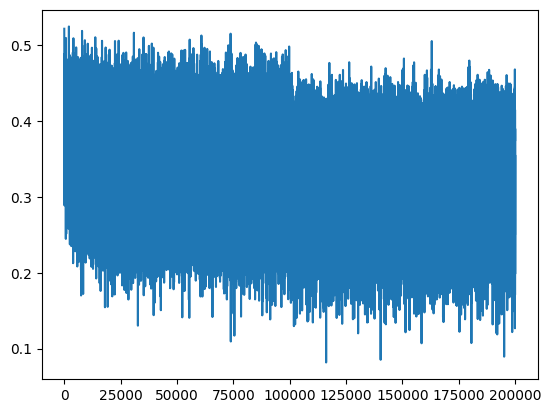

In [38]:
plt.plot(lossi) #is hockey stick shaped when the first loss is high but it disappears when we reduce the first loss by reducing initialised W2 and making b2 0

In [ ]:
@torch.no_grad() #this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split]
    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    h_pre_act = emb_cat @ W1 + b1 #hidden layer pre activation
    #h_pre_act = bn_gain * (h_pre_act - h_pre_act.mean(0, keepdim=True)) / h_pre_act.std(0, keepdim=True) + bn_bias
    h_pre_act = bn_gain * (h_pre_act - bn_mean_running) / bn_std_running + bn_bias
    h = torch.tanh(h_pre_act) #hidden layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0376646518707275
val 2.106989622116089


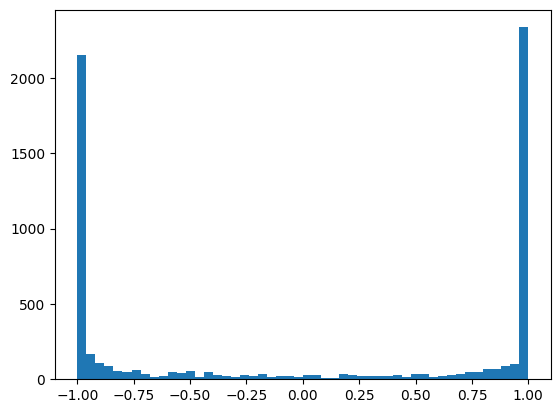

In [ ]:
# plt.hist(h.view(-1).tolist(), 50); #we can see clearly that most of the values are near -1 and 1 and it's not smooth which is a problem
#when the values or 1 or -1 the gradient of tanh through chain rule becomes 0 because of (1-t**2)*out.grad

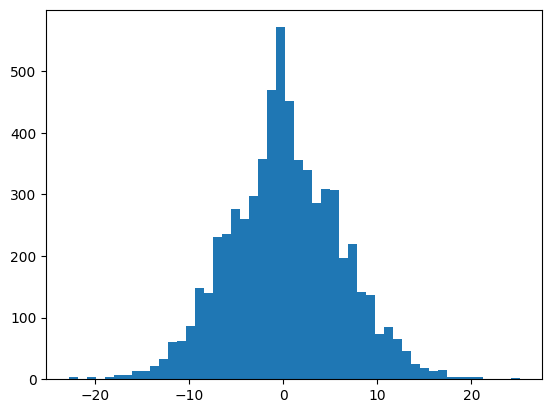

In [ ]:
# plt.hist(h_pre_act.view(-1).tolist(), 50); #the above is happening becaise h_pre_act reange is broad and tanh of anything outside -1,1 is almost -1 or 1

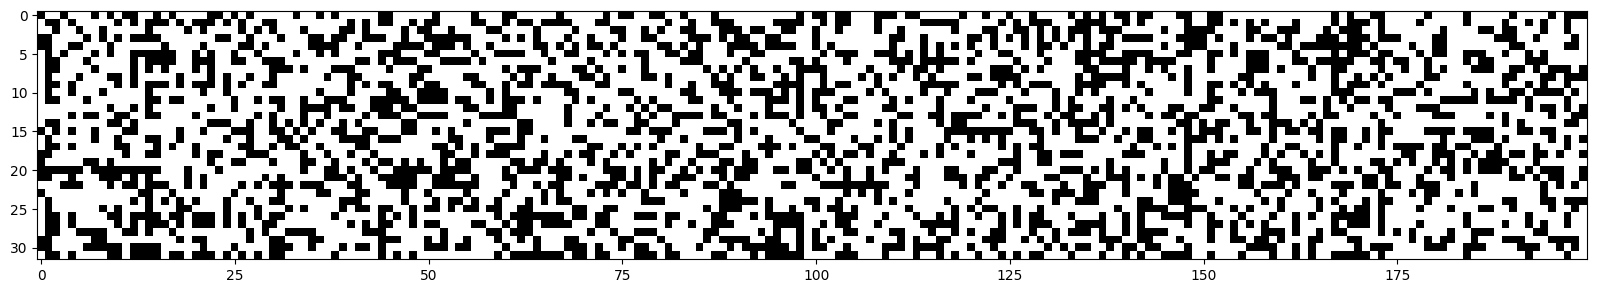

In [ ]:
# plt.figure(figsize=(20,10)) #intepret the diagram as follows: 32 examples or 32 sets of 30 dimensional(10dims*3chars) for each of the 200 neurons
# plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest') #so if any column is completely white it means no example is reducing that neuron's (column) gradient and this is called a dead neuron

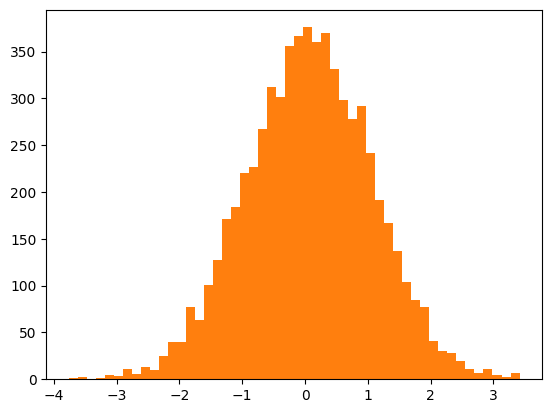

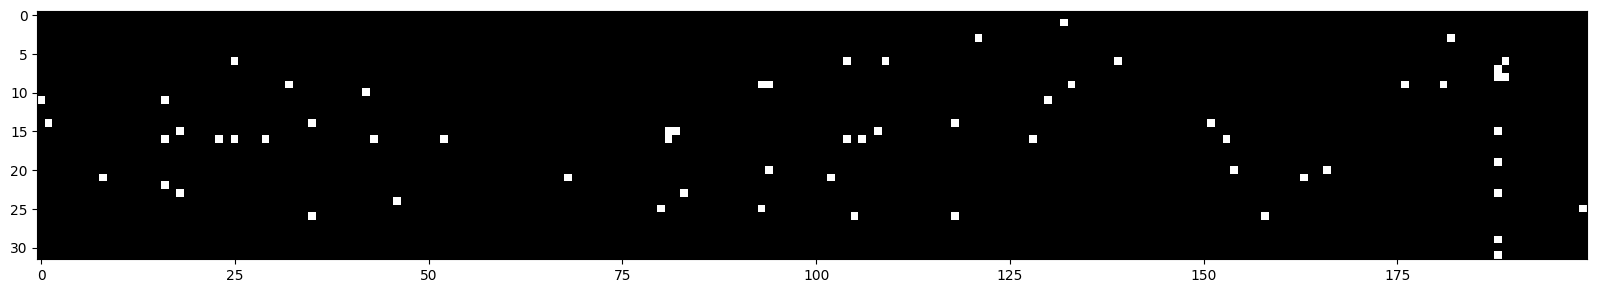

In [66]:
plt.hist(h.view(-1).tolist(), 50);
plt.hist(h_pre_act.view(-1).tolist(), 50);
plt.figure(figsize=(20,10)) 
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest') 

In [40]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 +b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(i_to_s[i] for i in out))

carman.
amille.
khyrmyn.
reet.
khalayane.
mahnen.
deliah.
jareei.
nellara.
chaiivon.
legen.
ham.
jorn.
quintin.
lilea.
jadiquinterri.
jarysia.
kael.
dustine.
deciia.


In [35]:
logits = torch.tensor([80.0, 160.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([1.8049e-35, 1.0000e+00, 0.0000e+00, 0.0000e+00]), tensor(inf))

In [31]:
a = torch.tensor([0.9,1.0,0.8,0])
-a.log()

tensor([0.1054, -0.0000, 0.2231,    inf])